# Evaluation Comparison

# 1. Load Data

In [19]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path_pre = "Pre-Evaluation (French)(1-31).xlsx"
group_path = "Post-Evaluation (French - Group)(1-24).xlsx"
indiv_path = "Post-Evaluation (French - Individual) (1-5).xlsx"

df_pre = pd.read_excel(file_path_pre)
group_df = pd.read_excel(group_path)
indiv_df = pd.read_excel(indiv_path)


# Standardize and combine
common_cols = set(group_df.columns).intersection(set(indiv_df.columns))
combined_df = pd.concat([group_df[list(common_cols)], indiv_df[list(common_cols)]], ignore_index=True)

# Drop completely empty rows 
combined_df.dropna(how='all', inplace=True)
indiv_df.dropna(how='all', inplace=True)
group_df.dropna(how='all', inplace=True)
df_pre.dropna(how='all', inplace=True)



## 2. Clean and Prep

In [20]:
# Drop unneeded metadata columns (except Startzeit)
meta_cols = ['ID', 'E-Mail', 'Name', 'Zeitpunkt der letzten Änderung']
df_clean_pre = df_pre.drop(columns=meta_cols, errors='ignore')
df_clean = combined_df.drop(columns=meta_cols, errors='ignore')
df_clean_indiv = indiv_df.drop(columns=meta_cols, errors='ignore')
df_clean_group = group_df.drop(columns=meta_cols, errors='ignore')


# make group which started at the same time
for df in [df_clean, df_clean_group, df_clean_indiv, df_clean_pre]:
    df['Startzeit'] = pd.to_datetime(df['Startzeit'], errors='coerce')
    df['TimeGroup'] = df['Startzeit'].dt.round('15min')

# Convert to numeric
def safe_numeric(df):
    keep_cols = ['Startzeit', 'TimeGroup']
    numeric_df = df.drop(columns=[col for col in keep_cols if col in df.columns], errors='ignore')
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
    return pd.concat([df[keep_cols], numeric_df], axis=1)

df_clean_pre = safe_numeric(df_clean_pre)
df_clean = safe_numeric(df_clean)
df_clean_group = safe_numeric(df_clean_group)
df_clean_indiv = df_clean_indiv.apply(pd.to_numeric, errors='coerce') 

df_clean_pre = df_clean_pre.dropna(thresh=5)
df_clean = df_clean.dropna(thresh=5)
df_clean_indiv = df_clean_indiv.dropna(thresh=5)
df_clean_group = df_clean_group.dropna(thresh=5)


## 3. Evaluation

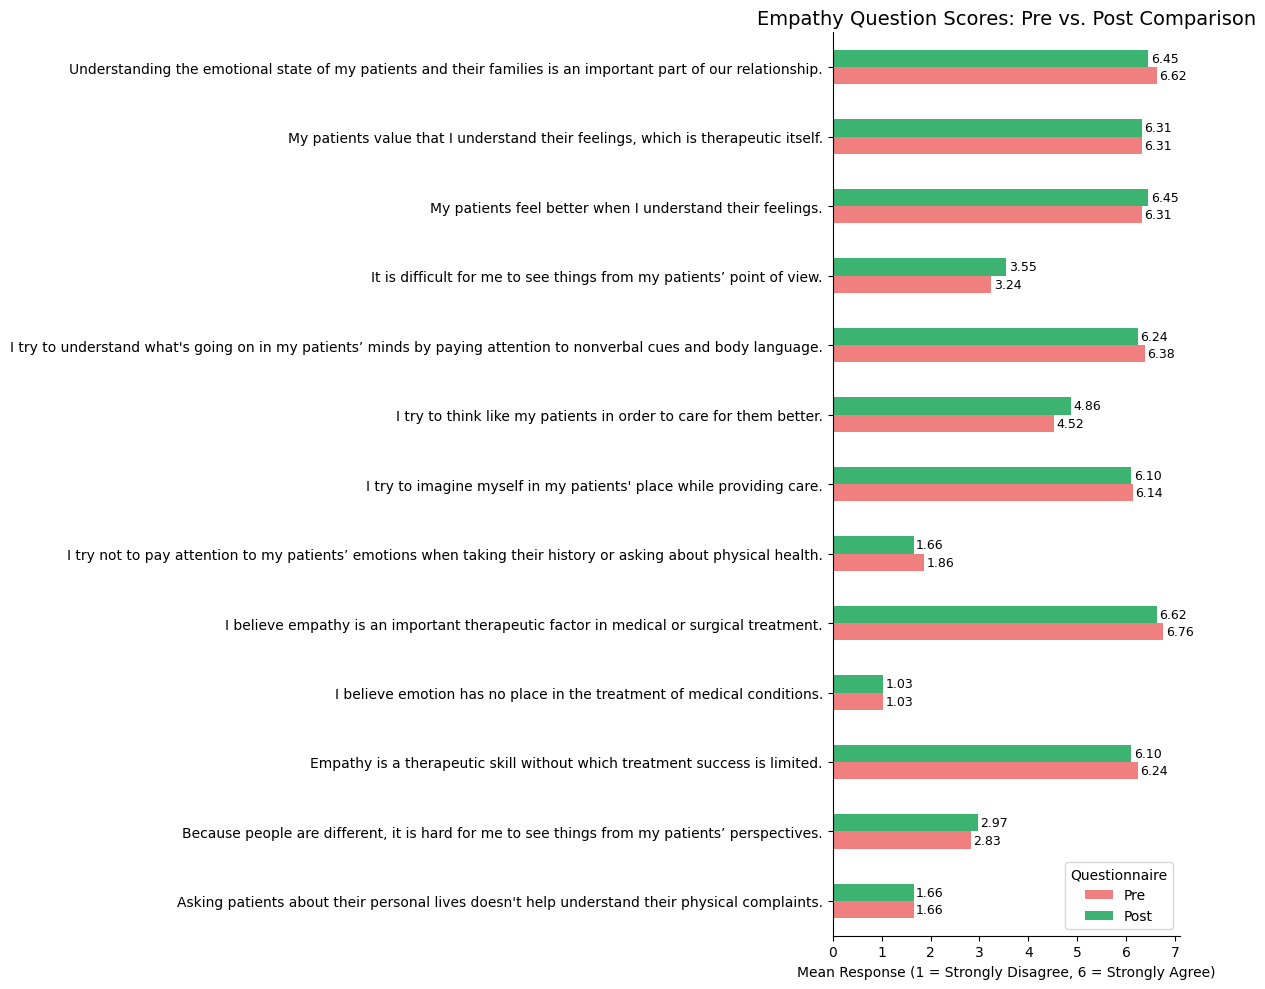

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# all questions
french_questions = [
    'Mes patients se sentent mieux lorsque je comprends leurs sentiments.',
    "Il m'est difficile d'envisager les choses du point de vue de mes patients.",
    "Parce que les gens sont différents, il m'est difficile de voir les choses du point de vue de mes patients.",
    "J'essaie de ne pas prêter attention aux émotions de mes patients lorsque je recueille leurs antécédents ou que je leur pose des questions sur leur santé physique.",
    "J'essaie de m'imaginer à la place de mes patients lorsque je leur prodigue des soins.",
    'Mes patients apprécient que je comprenne leurs sentiments, ce qui est thérapeutique en soi.',
    "Demander aux patients ce qui se passe dans leur vie personnelle n'aide pas à comprendre leurs plaintes physiques.",
    "J'essaie de comprendre ce qui se passe dans l'esprit de mes patients en prêtant attention à leurs signaux non verbaux et à leur langage corporel.",
    "Je pense que l'émotion n'a pas sa place dans le traitement des maladies médicales.",
    "L'empathie est une compétence thérapeutique sans laquelle le succès du traitement est limité.",
    'Un élément important de la relation avec mes patients est ma compréhension de leur état émotionnel et de celui de leur famille.',
    "J'essaie de penser comme mes patients afin de mieux les soigner.",
    "Je pense que l'empathie est un facteur thérapeutique important dans le cadre d'un traitement médical ou chirurgical."
]

english_questions = [
    "My patients feel better when I understand their feelings.",
    "It is difficult for me to see things from my patients’ point of view.",
    "Because people are different, it is hard for me to see things from my patients’ perspectives.",
    "I try not to pay attention to my patients’ emotions when taking their history or asking about physical health.",
    "I try to imagine myself in my patients' place while providing care.",
    "My patients value that I understand their feelings, which is therapeutic itself.",
    "Asking patients about their personal lives doesn't help understand their physical complaints.",
    "I try to understand what's going on in my patients’ minds by paying attention to nonverbal cues and body language.",
    "I believe emotion has no place in the treatment of medical conditions.",
    "Empathy is a therapeutic skill without which treatment success is limited.",
    "Understanding the emotional state of my patients and their families is an important part of our relationship.",
    "I try to think like my patients in order to care for them better.",
    "I believe empathy is an important therapeutic factor in medical or surgical treatment."
]

question_map = dict(zip(french_questions, english_questions))
df_renamed = df_clean.rename(columns=question_map)
df_renamed_indiv = df_clean_indiv.rename(columns=question_map)
df_renamed_group = df_clean_group.rename(columns=question_map)
df_pre_renamed = df_clean_pre.rename(columns=question_map)

# Select and clean 
df_attitudes = df_renamed[english_questions].apply(pd.to_numeric, errors='coerce')
df_attitudes = df_attitudes.dropna(thresh=5)

# same with pre
df_attitudes_pre = df_pre_renamed[english_questions].apply(pd.to_numeric, errors='coerce')
df_attitudes_pre = df_attitudes_pre.dropna(thresh=5)

mean_scores_pre = df_attitudes_pre.mean()
mean_scores_post = df_attitudes.mean()

# Combine into one df
comparison_df = pd.DataFrame({
    "Pre": mean_scores_pre,
    "Post": mean_scores_post
}).sort_index()


ax = comparison_df.plot(kind='barh', figsize=(12, 10), color=['lightcoral', 'mediumseagreen'])

for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if not pd.isna(width):
            ax.annotate(f"{width:.2f}",
                        xy=(width + 0.05, bar.get_y() + bar.get_height() / 2),
                        va='center', ha='left', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Empathy Question Scores: Pre vs. Post Comparison", fontsize=14)
plt.xlabel("Mean Response (1 = Strongly Disagree, 6 = Strongly Agree)")
plt.legend(title="Questionnaire")
plt.tight_layout()
plt.show()


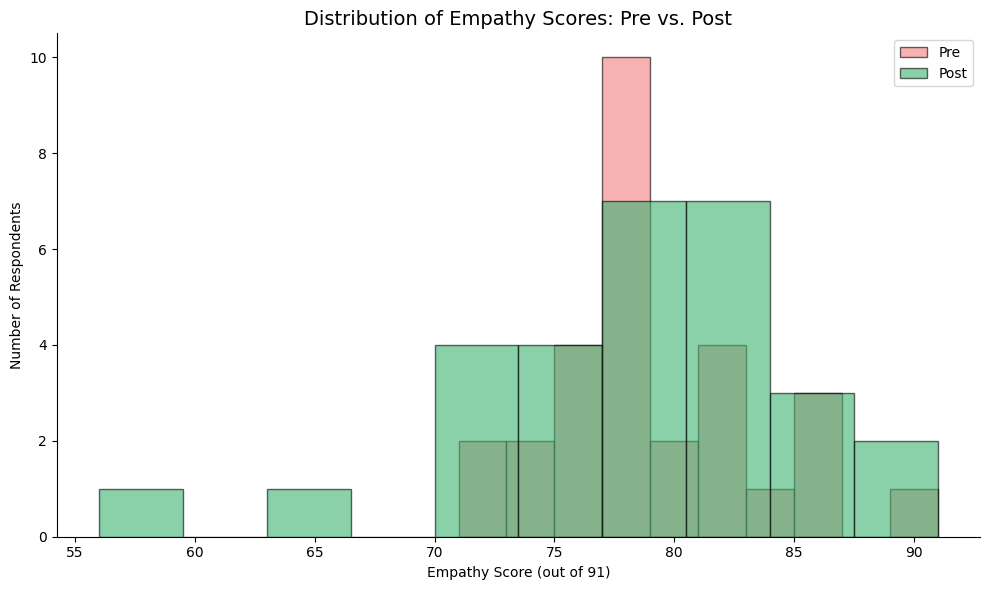

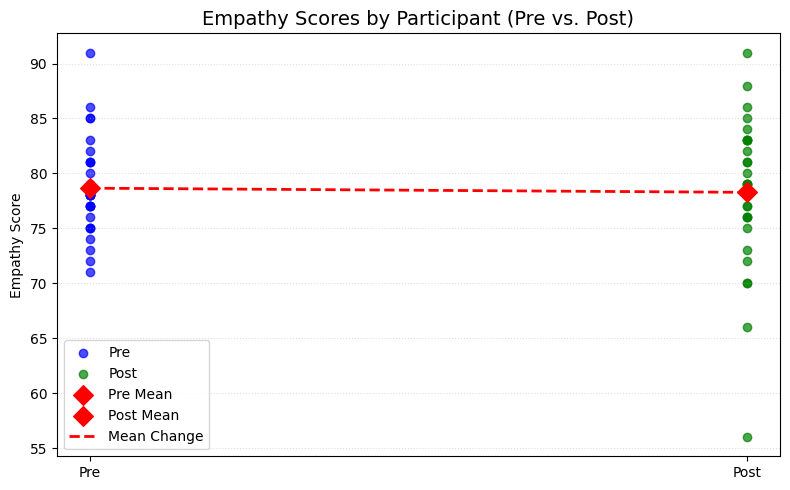

In [22]:
def reverse_score(series):
    return series.map({1: 7, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1})

reverse_items = [
    "It is difficult for me to see things from my patients’ point of view.",
    "Because people are different, it is hard for me to see things from my patients’ perspectives.",
    "I try not to pay attention to my patients’ emotions when taking their history or asking about physical health.",
    "Asking patients about their personal lives doesn't help understand their physical complaints.",
    "I believe emotion has no place in the treatment of medical conditions."
]

# post
df_empathy_post = df_attitudes.copy()
for col in reverse_items:
    if col in df_empathy_post.columns:
        df_empathy_post[col] = reverse_score(df_empathy_post[col])
df_empathy_post["Empathy Score"] = df_empathy_post.sum(axis=1)

# pre
df_pre_renamed = df_clean_pre.rename(columns=question_map)
df_attitudes_pre = df_pre_renamed[english_questions].apply(pd.to_numeric, errors='coerce').dropna(thresh=5)

df_empathy_pre = df_attitudes_pre.copy()
for col in reverse_items:
    if col in df_empathy_pre.columns:
        df_empathy_pre[col] = reverse_score(df_empathy_pre[col])
df_empathy_pre["Empathy Score"] = df_empathy_pre.sum(axis=1)

# Plot
plt.figure(figsize=(10, 6))

df_empathy_pre["Empathy Score"].plot(kind='hist', bins=10, alpha=0.6, label='Pre', color='lightcoral', edgecolor='black')
df_empathy_post["Empathy Score"].plot(kind='hist', bins=10, alpha=0.6, label='Post', color='mediumseagreen', edgecolor='black')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("Distribution of Empathy Scores: Pre vs. Post", fontsize=14)
plt.xlabel("Empathy Score (out of 91)")
plt.ylabel("Number of Respondents")
plt.legend()
plt.tight_layout()
plt.show()

pre_scores = df_empathy_pre["Empathy Score"].reset_index(drop=True)
post_scores = df_empathy_post["Empathy Score"].reset_index(drop=True)

# Calculate means
pre_mean = pre_scores.mean()
post_mean = post_scores.mean()

plt.figure(figsize=(8, 5))
plt.scatter([0] * len(pre_scores), pre_scores, color='blue', label='Pre', alpha=0.7)
plt.scatter([1] * len(post_scores), post_scores, color='green', label='Post', alpha=0.7)

# Mean 
plt.scatter(0, pre_mean, color='red', s=100, marker='D', label='Pre Mean')
plt.scatter(1, post_mean, color='red', s=100, marker='D', label='Post Mean')

# Line means
plt.plot([0, 1], [pre_mean, post_mean], color='red', linestyle='--', linewidth=2, label='Mean Change')

plt.xticks([0, 1], ['Pre', 'Post'])
plt.ylabel("Empathy Score")
plt.title("Empathy Scores by Participant (Pre vs. Post)", fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()




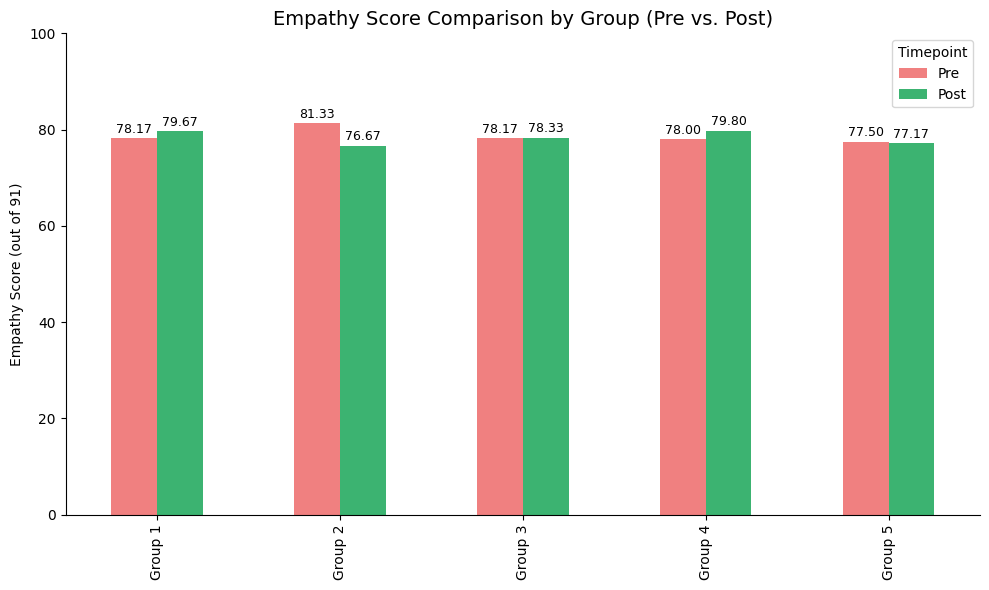

In [23]:
# function to compute empathy score
def compute_empathy_score(path):
    df = pd.read_excel(path)
    df.columns = df.columns.str.strip()
    df = df.rename(columns=question_map)
    df_subset = df[english_questions].apply(pd.to_numeric, errors='coerce').dropna(thresh=5)
    for col in reverse_items:
        if col in df_subset.columns:
            df_subset[col] = reverse_score(df_subset[col])
    df_subset["Empathy Score"] = df_subset.sum(axis=1)
    return df_subset["Empathy Score"].mean()

# Load and compute for each group
empathy_scores_by_group = {
    "Group 1": [compute_empathy_score("Group-1-PRE.xlsx"),
                compute_empathy_score("Group-1-POST.xlsx")],
    "Group 2": [compute_empathy_score("Group-2-PRE.xlsx"),
                compute_empathy_score("Group-2-POST.xlsx")],
    "Group 3": [compute_empathy_score("Group-3-PRE.xlsx"),
                compute_empathy_score("Group-3-POST.xlsx")],
    "Group 4": [compute_empathy_score("Group-4-PRE.xlsx"),
                compute_empathy_score("Group-4-POST.xlsx")],
    "Group 5": [compute_empathy_score("Group-5-PRE.xlsx"),
                compute_empathy_score("Group-5-POST.xlsx")],
}

# Create df
df_empathy_comparison = pd.DataFrame.from_dict(
    empathy_scores_by_group, orient='index', columns=['Pre', 'Post']
)

# Plot
ax = df_empathy_comparison.plot(kind='bar', figsize=(10, 6), color=['lightcoral', 'mediumseagreen'])

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height + 0.5),
                    ha='center', va='bottom', fontsize=9)

ax.set_title("Empathy Score Comparison by Group (Pre vs. Post)", fontsize=14)
ax.set_ylabel("Empathy Score (out of 91)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 100)
plt.legend(title="Timepoint")
plt.tight_layout()
plt.show()

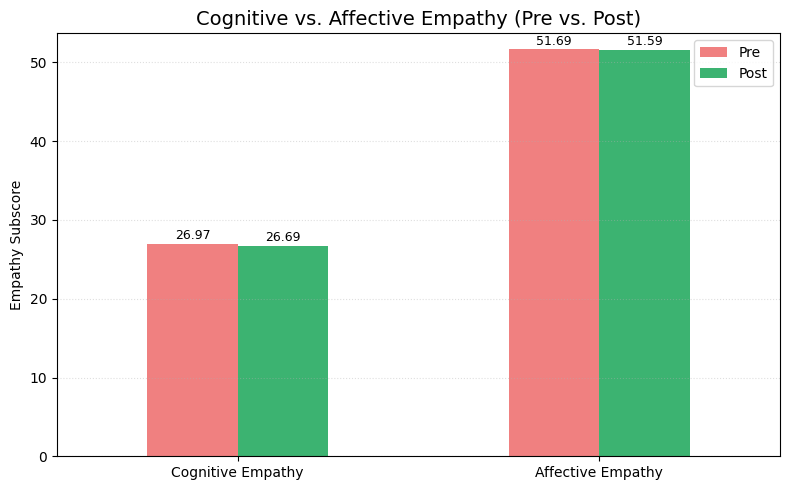

In [24]:
# Cognitive and Affective Empathy Analysis
cognitive_items = [
    "It is difficult for me to see things from my patients’ point of view.",
    "Because people are different, it is hard for me to see things from my patients’ perspectives.",
    "I try to imagine myself in my patients' place while providing care.",
    "I try to understand what's going on in my patients’ minds by paying attention to nonverbal cues and body language.",
    "I try to think like my patients in order to care for them better."
]

affective_items = [
    "My patients feel better when I understand their feelings.",
    "I try not to pay attention to my patients’ emotions when taking their history or asking about physical health.",
    "My patients value that I understand their feelings, which is therapeutic itself.",
    "Asking patients about their personal lives doesn't help understand their physical complaints.",
    "I believe emotion has no place in the treatment of medical conditions.",
    "Empathy is a therapeutic skill without which treatment success is limited.",
    "Understanding the emotional state of my patients and their families is an important part of our relationship.",
    "I believe empathy is an important therapeutic factor in medical or surgical treatment."
]

df_cog_aff_pre = df_attitudes_pre.copy()
df_cog_aff_post = df_attitudes.copy()

for col in reverse_items:
    if col in df_cog_aff_pre.columns:
        df_cog_aff_pre[col] = reverse_score(df_cog_aff_pre[col])
    if col in df_cog_aff_post.columns:
        df_cog_aff_post[col] = reverse_score(df_cog_aff_post[col])

# Calculate scores
df_cog_aff_pre["Cognitive Empathy"] = df_cog_aff_pre[cognitive_items].sum(axis=1)
df_cog_aff_pre["Affective Empathy"] = df_cog_aff_pre[affective_items].sum(axis=1)

df_cog_aff_post["Cognitive Empathy"] = df_cog_aff_post[cognitive_items].sum(axis=1)
df_cog_aff_post["Affective Empathy"] = df_cog_aff_post[affective_items].sum(axis=1)

# means
cog_aff_means = pd.DataFrame({
    "Pre": [
        df_cog_aff_pre["Cognitive Empathy"].mean(),
        df_cog_aff_pre["Affective Empathy"].mean()
    ],
    "Post": [
        df_cog_aff_post["Cognitive Empathy"].mean(),
        df_cog_aff_post["Affective Empathy"].mean()
    ]
}, index=["Cognitive Empathy", "Affective Empathy"])

# Plot comparison
ax = cog_aff_means.plot(kind="bar", figsize=(8, 5), color=['lightcoral', 'mediumseagreen'])
plt.title("Cognitive vs. Affective Empathy (Pre vs. Post)", fontsize=14)
plt.ylabel("Empathy Subscore")
plt.xticks(rotation=0)
plt.ylim(0, cog_aff_means.values.max() + 2)
plt.grid(axis='y', linestyle=':', alpha=0.4)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height + 0.2),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Comparison of Perception

    Distressed  Attentive  Ashamed  Enthusiastic  Irritated  Inspired  \
0          2.0        4.0      1.0           3.0        1.0       3.0   
1          1.0        5.0      1.0           3.0        1.0       4.0   
2          2.0        5.0      1.0           1.0        2.0       1.0   
3          3.0        5.0      1.0           2.0        1.0       1.0   
4          3.0        5.0      1.0           1.0        1.0       1.0   
5          1.0        4.0      1.0           5.0        2.0       5.0   
6          2.0        5.0      1.0           3.0        1.0       3.0   
7          3.0        4.0      1.0           3.0        2.0       2.0   
8          3.0        4.0      3.0           2.0        4.0       2.0   
9          1.0        4.0      1.0           4.0        2.0       3.0   
10         2.0        5.0      1.0           3.0        1.0       3.0   
11         2.0        3.0      1.0           2.0        2.0       2.0   
12         4.0        5.0      1.0           2.0   

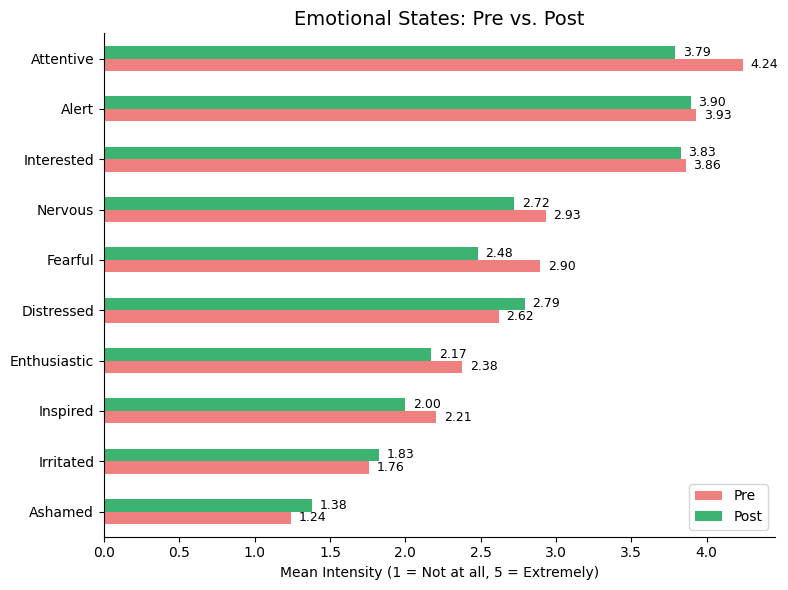

In [25]:
# Emotion Translation Map
emotion_map = {
    "Angoissé(e)": "Distressed",
    "Attentif(ve)": "Attentive",
    "Honteux(se)": "Ashamed",
    "Enthousiaste": "Enthusiastic",
    "Irrité(e)": "Irritated",
    "Inspiré(e)": "Inspired",
    "Nerveux(se)": "Nervous",
    "Intéressé(e)": "Interested",
    "Alerte": "Alert",
    "Craintif(ve)": "Fearful"
}

df_clean.columns = df_clean.columns.str.strip()
df_clean_pre.columns = df_clean_pre.columns.str.strip()

# Extract and rename 
df_emotions_pre = df_clean_pre[list(emotion_map.keys())].rename(columns=emotion_map).apply(pd.to_numeric, errors='coerce')
df_emotions_post = df_clean[list(emotion_map.keys())].rename(columns=emotion_map).apply(pd.to_numeric, errors='coerce')
print(df_emotions_pre.reset_index(drop=True))
print(df_emotions_post.reset_index(drop=True))

# Compute means
pre_means = df_emotions_pre.mean()
print(pre_means.reset_index(drop=True))
post_means = df_emotions_post.mean()
print(post_means.reset_index(drop=True))

# Combine for plotting
comparison = pd.DataFrame({'Pre': pre_means, 'Post': post_means})
comparison = comparison.sort_values(by='Pre')  # optional sorting

# Plot
ax = comparison.plot(kind='barh', figsize=(8, 6), color=['lightcoral', 'mediumseagreen'])

for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if not pd.isna(width):
            ax.annotate(f"{width:.2f}",
                        xy=(width + 0.05, bar.get_y() + bar.get_height() / 2),
                        va='center', ha='left', fontsize=9)


ax.set_title("Emotional States: Pre vs. Post", fontsize=14)
ax.set_xlabel("Mean Intensity (1 = Not at all, 5 = Extremely)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## per Group

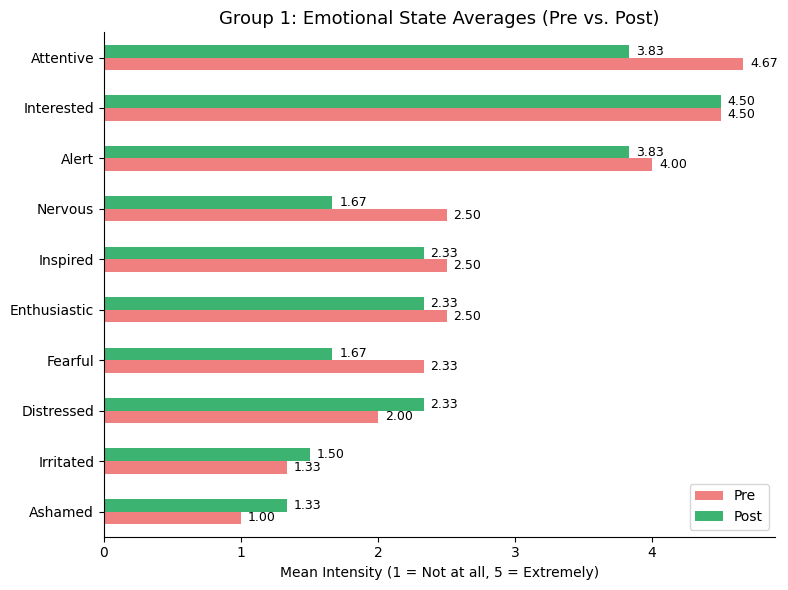

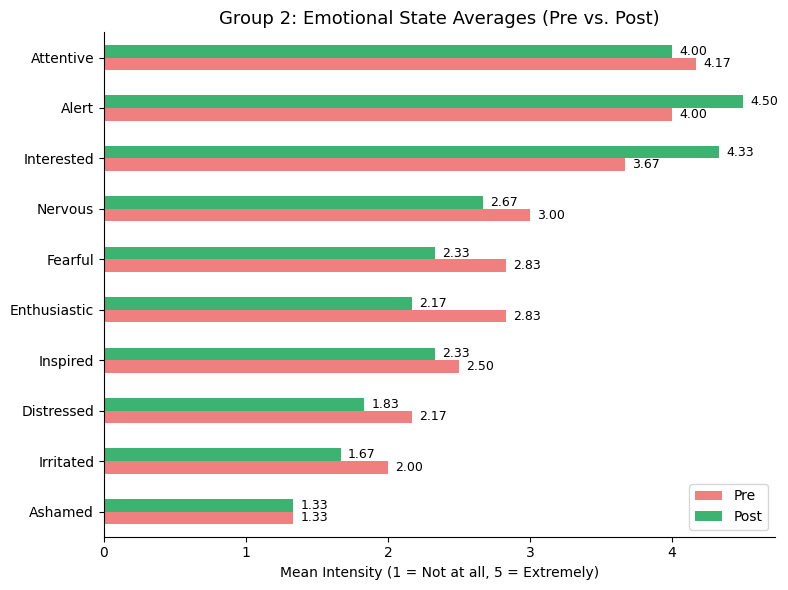

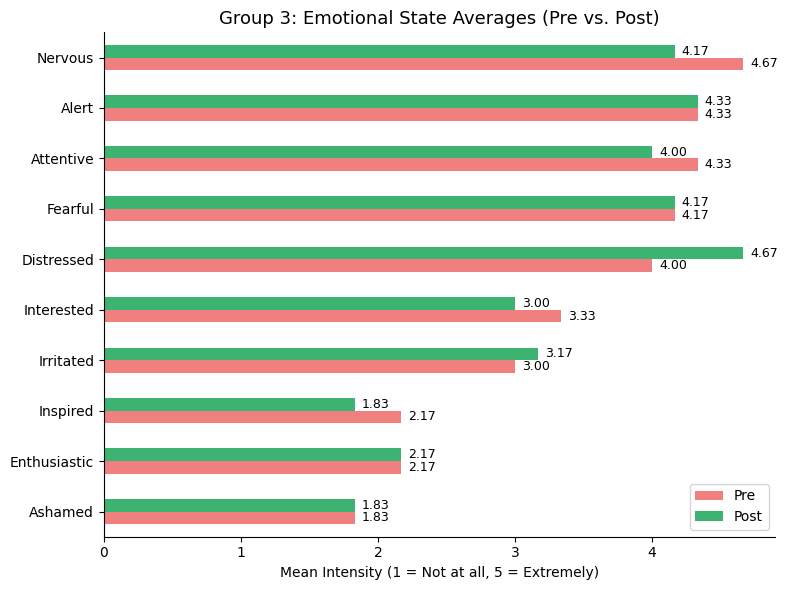

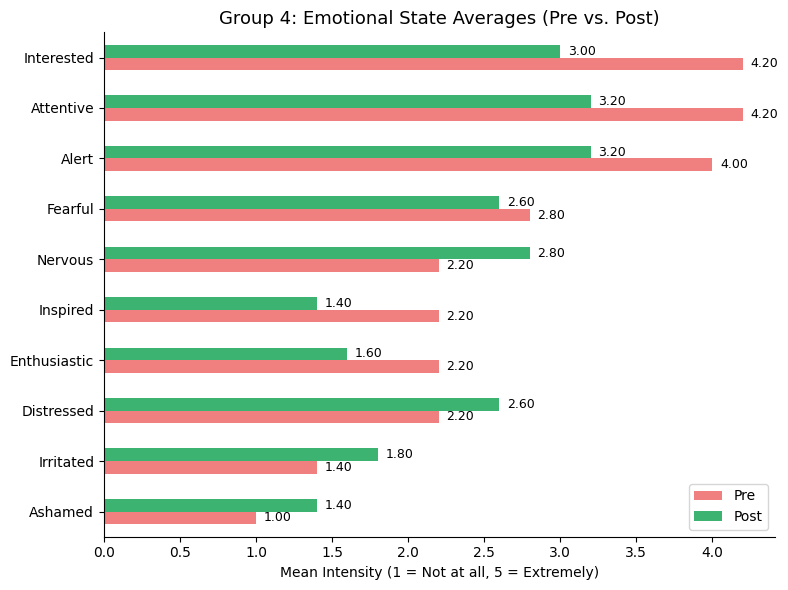

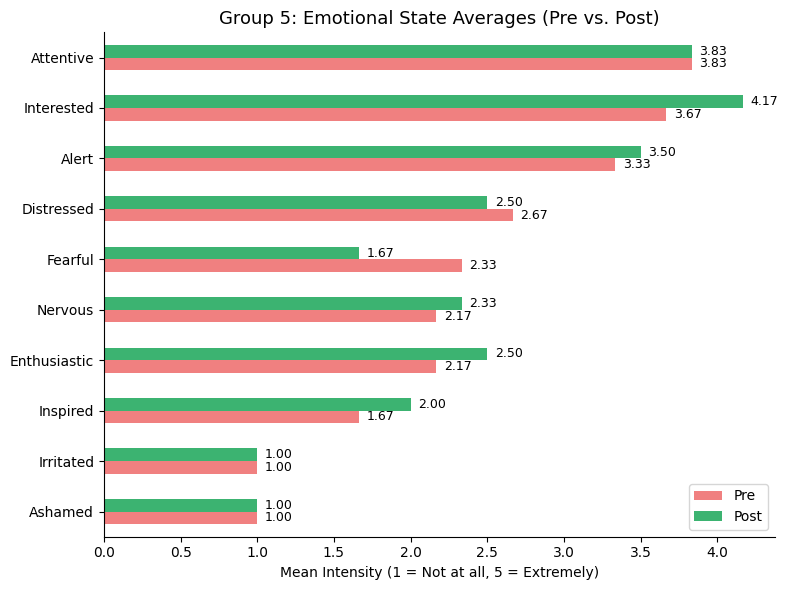

In [26]:

# Function to compute average emotion scores 
def compute_emotion_means(path):
    df = pd.read_excel(path)
    df.columns = df.columns.str.strip()
    df_emotions = df[list(emotion_map.keys())].rename(columns=emotion_map)
    df_emotions = df_emotions.apply(pd.to_numeric, errors='coerce')
    return df_emotions.mean()

emotion_scores_by_group = {
    "Group 1": [compute_emotion_means("Group-1-PRE.xlsx"),
                compute_emotion_means("Group-1-POST.xlsx")],
    "Group 2": [compute_emotion_means("Group-2-PRE.xlsx"),
                compute_emotion_means("Group-2-POST.xlsx")],
    "Group 3": [compute_emotion_means("Group-3-PRE.xlsx"),
                compute_emotion_means("Group-3-POST.xlsx")],
    "Group 4": [compute_emotion_means("Group-4-PRE.xlsx"),
                compute_emotion_means("Group-4-POST.xlsx")],
    "Group 5": [compute_emotion_means("Group-5-PRE.xlsx"),
                compute_emotion_means("Group-5-POST.xlsx")],
}

# plot
for group, (pre_scores, post_scores) in emotion_scores_by_group.items():
    comparison = pd.DataFrame({'Pre': pre_scores, 'Post': post_scores})
    comparison = comparison.sort_values(by='Pre') 

    ax = comparison.plot(kind='barh', figsize=(8, 6), color=['lightcoral', 'mediumseagreen'])

    for container in ax.containers:
        for bar in container:
            width = bar.get_width()
            if not pd.isna(width):
                ax.annotate(f"{width:.2f}",
                            xy=(width + 0.05, bar.get_y() + bar.get_height() / 2),
                            va='center', ha='left', fontsize=9)

    ax.set_title(f"{group}: Emotional State Averages (Pre vs. Post)", fontsize=13)
    ax.set_xlabel("Mean Intensity (1 = Not at all, 5 = Extremely)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


        Emotion  Pre Mean  Post Mean  t-statistic  p-value  Significant
0     Attentive      4.24       3.79       -1.924   0.0599        False
1       Fearful      2.90       2.48       -1.287   0.2041        False
2       Ashamed      1.24       1.38        0.800   0.4273        False
3  Enthusiastic      2.38       2.17       -0.768   0.4458        False
4      Inspired      2.21       2.00       -0.756   0.4526        False
5       Nervous      2.93       2.72       -0.603   0.5491        False
6    Distressed      2.62       2.79        0.503   0.6176        False
7     Irritated      1.76       1.83        0.215   0.8305        False
8         Alert      3.93       3.90       -0.128   0.8983        False
9    Interested      3.86       3.83       -0.113   0.9104        False


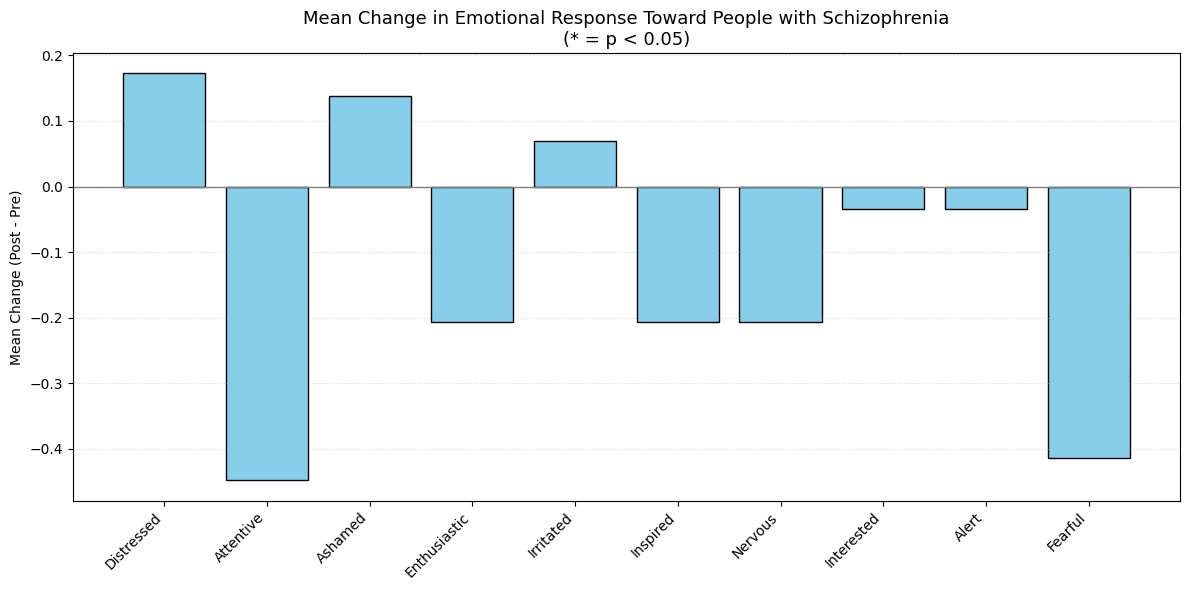

In [27]:
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

emotions = list(emotion_map.values())
mean_diffs = []
p_values = []

# Results will be saved here
results = []

# Loop through each emotion to compare pre and post scores using an independent samples t-test
for emotion in emotions:
    pre = df_emotions_pre[emotion]
    post = df_emotions_post[emotion]
    
    # Calculate mean difference (Post - Pre)
    diff = post.mean() - pre.mean()
    mean_diffs.append(diff)
    
    # Perform independent samples t-test
    stat, p = ttest_ind(post, pre, equal_var=False) 
    p_values.append(p)

    results.append({
        "Emotion": emotion,
        "Pre Mean": round(pre.mean(), 2),
        "Post Mean": round(post.mean(), 2),
        "t-statistic": round(stat, 3),
        "p-value": round(p, 4)
    })

# Convert results to df
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="p-value").reset_index(drop=True)
df_results["Significant"] = df_results["p-value"] < 0.05
print(df_results)

# Plot
x = np.arange(len(emotions))
plt.figure(figsize=(12, 6))
bars = plt.bar(x, mean_diffs, color='skyblue', edgecolor='black')
plt.axhline(0, color='gray', linewidth=1)

for i, (bar, p) in enumerate(zip(bars, p_values)):
    height = bar.get_height()
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    else:
        star = ''
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.03, star,
             ha='center', va='bottom', fontsize=14)

plt.xticks(x, emotions, rotation=45, ha='right')
plt.ylabel('Mean Change (Post - Pre)')
plt.title('Mean Change in Emotional Response Toward People with Schizophrenia\n(* = p < 0.05)', fontsize=13)
plt.tight_layout()
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()
